# Newsgroups Classifier

Apply machine learning knowledge through document classification using supervised learning techniques and to perform a performance analysis of the learned
classifier. The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=69d42120d4a9cd806068f34a30042619970ff3c69be40d57511e84392b5ceb9a
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
import wget
random.seed()
import warnings
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
lemmatizer = WordNetLemmatizer()
stemmer=LancasterStemmer()
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Error downloading 'wordnet' from
[nltk_data]     <https://raw.githubusercontent.com/nltk/nltk_data/gh-
[nltk_data]     pages/packages/corpora/wordnet.zip>:   [Errno 104]
[nltk_data]     Connection reset by peer


In [ ]:
filename = wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip
DATA_DIR = "20_newsgroups"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: 20_newsgroups/talk.politics.guns/54127  
  inflating: 20_newsgroups/talk.politics.guns/53302  
  inflating: 20_newsgroups/talk.politics.guns/54315  
  inflating: 20_newsgroups/talk.politics.guns/54771  
  inflating: 20_newsgroups/talk.politics.guns/54543  
  inflating: 20_newsgroups/talk.politics.guns/55233  
  inflating: 20_newsgroups/talk.politics.guns/55039  
  inflating: 20_newsgroups/talk.politics.guns/54749  
  inflating: 20_newsgroups/talk.politics.guns/55234  
  inflating: 20_newsgroups/talk.politics.guns/54782  
  inflating: 20_newsgroups/talk.politics.guns/54544  
  inflating: 20_newsgroups/talk.politics.guns/54312  
  inflating: 20_newsgroups/talk.politics.guns/54120  
  inflating: 20_newsgroups/talk.politics.guns/53305  
  inflating: 20_newsgroups/talk.politics.guns/54915  
  inflating: 20_newsgroups/talk.politics.guns/54129  
  inflating: 20_newsgroups/talk.politics.guns/54586  
  inflating: 20_newsgroups/talk.politics.guns/54324  
 

In [ ]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [ ]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [ ]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [ ]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Part 1 Baseline
The function binary_baseline_data takes in a list of files and runs a baseline evaluation
based on a binary encoding of the most commonly words as feature set.

In [ ]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [ ]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

The feature set is first 1000 most common words, total amount of data is 19997, the amount of data used in training process is 70% of whole dataset and 30% of whole dataset for test. Hyperparameter is C value in Logistic Regression, which is 1 in baseline model.

In [ ]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9494177323712224
Test accuracy: 0.6771666666666667


Improve the feature set

In [ ]:
def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    import nltk
    nltk.download('stopwords')
    nltk.download('wordnet')
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.stem import LancasterStemmer
    lemmatizer = WordNetLemmatizer()
    stemmer=LancasterStemmer()
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    # Process word_list
    lower_words=[word.lower() for word in word_list]
    processed_words=[lemmatizer.lemmatize(word) for word in lower_words]
    processed_words=[stemmer.stem(word) for word in processed_words]


    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words=[word.lower() for word in file_words]
            file_words=[lemmatizer.lemmatize(word) for word in file_words]
            file_words=[stemmer.stem(word) for word in file_words]

            df_rows.append([1 if word in file_words else 0 for word in processed_words])      
    
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = processed_words)
    y =  [get_target(get_topic_name(file_path)) for file_path in file_list]

    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

In [ ]:
# get the baseline data
X, y = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier
# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=0.1).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Train accuracy: 0.8677573765806958
Test accuracy: 0.7075



Training accuracy is lower than before, but test accuracy is higher. The baseline model is overfitting because the difference between training and testing accuracy is significant. This result also shows that the overfitting issue is much less than before.

Different train-test splits can lead to different results. In order to get a more robust estimation of the performance of  classifier, we want to calculate the mean and the 95%
confidence interval on the accuracy of the classifier over a set of multiple runs with random
splits.

In [ ]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(num_tests):
        random_state=random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
        clf = LogisticRegression(C=0.1).fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        train_results.append(train_accuracy)
        test_results.append(test_accuracy)




    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [ ]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.8681360291491034
Train confidence interval over 10 random splits: [0.866666772843583, 0.8696052854546238]
Test mean accuracy over 10 random splits: 0.7131
Test confidence interval over 10 random splits: [0.7102197567642791, 0.7159802432357208]


They are more informative than a single trail. Because in the process of spliting data, there is a chance that the distribution of traning and test data is quite different or too similar, especially for a small dataset, if we only juedge a model by a single trail, then the model might be overestimated or underestimated.

Implement a function random_cm that produces a confusion matrix that is based on multiple
random splits.

In [ ]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here
    for i in range(num_tests):
        random_state=random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
        clf = LogisticRegression(C=0.1).fit(X_train, y_train)
        y_test_predict = clf.predict(X_test)
        cm_list.append(confusion_matrix(y_test,y_test_predict))

    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = np.array(cm_list).sum(axis=0)

    # validate return type
    assert isinstance(combined_cm, np.ndarray), "return type"
    
    return combined_cm

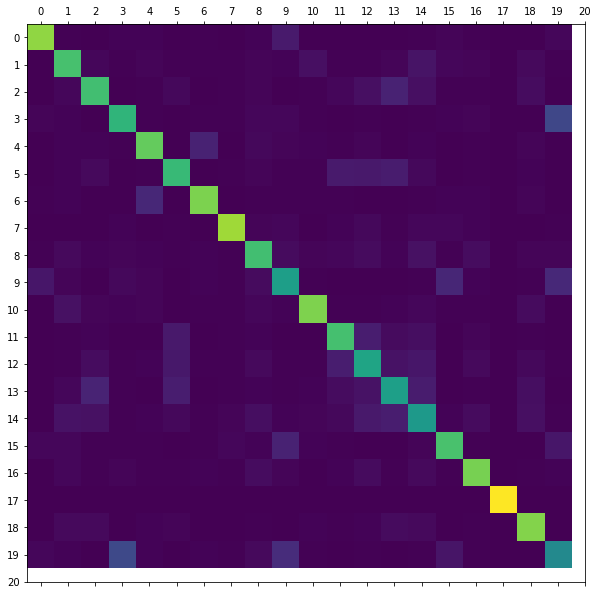

In [ ]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

(4,6), (2,13), (5,11), (5,12), (5,13), (3,19), (9,15), (9,19), (11,12), (13,14), (15,19) are more easily confused (target, prediction) pairs, because these pairs' color is lighter than other pairs' except for the diagonal, lighter color corresponds to higher value, which means these pairs are more likely to be misclassified.

## Part 2 Number of words selection
In this part, I will vary this number of words used as features and see how it affects the
results.

Calculate the train accuracy and the test accuracy when using p percent of the features,
p = [10%; 20%; 40%; 60%; 80%; 100%].

In [ ]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        # ......
        clf = LogisticRegression(C=0.1).fit(X_train_subset, y_train)
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

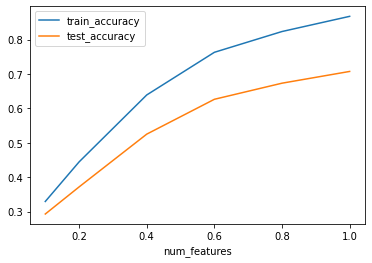

In [ ]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

At the begining(fewer features), the trend is pretty strong and after 0.6 the trend becomes weaker. Because when a model already has a lot of information about the dataset to make judgement, adding more information might be less helpful than beginning. Also, the difference between train_accuracy and test_accuracy is small with fewer features but it becomes greater when num_features increases, which means the model is more likely to overfit with more features.

## Part 3 Hyperparameter tuning


Calculate the train accuracy and the test accuracy for different values for the hyperparameter
C: [10−3, 10−2, ..., 100, ..., 103].

In [ ]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        # ......
        clf = LogisticRegression(C=param).fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

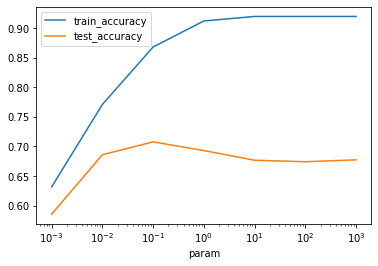

In [ ]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

There is a c value for the model to reach optimal performance on test set, and that is 0.1. C value corresponds to the regularization strength of the model, with lower c value, the model is punished too hard that it can't learn anything(underfit), with higher c value, the model is more likely to overfit. That is also the reason that training accuracy is lower with lower c value and higher with higher c value.

## Part 4 Feature encoding
In this question, I will evaluate the effect of using term-frequency (TF) encoding instead of a
binary encoding on this dataset.

Implement a TF encoding in the function tf_improved_data.

In [ ]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    import nltk
    nltk.download('stopwords')
    nltk.download('wordnet')
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.stem import LancasterStemmer
    lemmatizer = WordNetLemmatizer()
    stemmer=LancasterStemmer()

    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    # Process word_list
    lower_words=[word.lower() for word in word_list]
    processed_words=[lemmatizer.lemmatize(word) for word in lower_words]
    processed_words=[stemmer.stem(word) for word in processed_words]



    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        tf_dict={}
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words=[word.lower() for word in file_words]
            file_words=[lemmatizer.lemmatize(word) for word in file_words]
            file_words=[stemmer.stem(word) for word in file_words]
            for each in processed_words:
                freq=file_words.count(each)
                tf_dict[each]=freq

            df_rows.append([tf_dict[word] if word in file_words else 0 for word in processed_words])

    
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = processed_words)
    y =  [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

Compare the two encodings by comparing the mean accuracy and 95% confidence interval. Use the function random_mean_ci from Part 1 and run enough trials to obtain nonoverlapping 95% CIs on the average accuracy of each method.

In [ ]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Train mean accuracy over 10 random splits: 0.7841894691719655
Train confidence interval over 10 random splits: [0.7813928673777679, 0.7869860709661631]
Test mean accuracy over 10 random splits: 0.68815
Test confidence interval over 10 random splits: [0.6855808985255663, 0.6907191014744338]


Binary encoding works better on this dataset, because term frequency prone to overfit the dataset.

## Part 5 Comparison vs. Naive Bayes


In this part, I will compare mean accuracy and 95% confidence interval of the logistic
regression classifier to a naive bayes (NB) classifier.

Implement a naive bayes classifier evaluated over multiple random splits in the function
nb_random_mean_ci

In [ ]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(num_tests):
        random_state=random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
        clf = MultinomialNB().fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

Run enough trials to obtain non-overlapping 95% CIs on the average accuracy of each classifier.

In [ ]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.6969922126169893
Train confidence interval over 10 random splits: [0.6950918364380814, 0.6988925887958972]
Test mean accuracy over 10 random splits: 0.6471166666666667
Test confidence interval over 10 random splits: [0.6416805555746614, 0.6525527777586719]


Logistic regression works better on this dataset, because naive bayes assumes conditionally independent of each term in the document which is not usually the case in real life.

## Part 6 Binary Logistic Regression


In this question I will build a binary logistic regression that is trained to classify the target
sci.med vs. any other target. Use the binary encoding of features of this question.

Implement the function binary_med_data that return the features and targets dataframe. In
this part there are only two possible targets: 1 for sci.med and 0 for any other label.

In [ ]:
def binary_med_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    import nltk
    nltk.download('stopwords')
    nltk.download('wordnet')
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.stem import LancasterStemmer
    lemmatizer = WordNetLemmatizer()
    stemmer=LancasterStemmer()
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    # Process word_list
    lower_words=[word.lower() for word in word_list]
    processed_words=[lemmatizer.lemmatize(word) for word in lower_words]
    processed_words=[stemmer.stem(word) for word in processed_words]
   


    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words=[word.lower() for word in file_words]
            file_words=[lemmatizer.lemmatize(word) for word in file_words]
            file_words=[stemmer.stem(word) for word in file_words]

            df_rows.append([1 if word in file_words else 0 for word in processed_words])      
    
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = processed_words)
    targets =  [get_target(get_topic_name(file_path)) for file_path in file_list]
    y=[1 if target==8 else 0 for target in targets]


    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])

    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

Calculate the average accuracy and 95% confidence interval over ten iterations

In [ ]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Train mean accuracy over 10 random splits: 0.9764878188183183
Train confidence interval over 10 random splits: [0.9760368000788975, 0.976938837557739]
Test mean accuracy over 10 random splits: 0.9695499999999999
Test confidence interval over 10 random splits: [0.9678517072826478, 0.971248292717352]


Confidence interval of accuracy on training and test set are both higher than multiclass logistic regression, which means binary logistic regression has better performance than multiclass logistic regression. Also, binary encoding of the target makes this dataset to be unbalanced, negative samples are a lot more than positive samples, which can also make binary logistic regrresion perform well on accuracy.

#Part 7: Classification with ranking
In this part I will again build a multi-class classification system. However, this time I
will be interested in the ranked results of your system. I will be putting together a system
to optimize the average precision score for classification.

In [ ]:
def data_q7(file_list, num_words = 5000):
    import nltk
    nltk.download('stopwords')
    nltk.download('wordnet')
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.stem import LancasterStemmer
    lemmatizer = WordNetLemmatizer()
    stemmer=LancasterStemmer()
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    # Process word_list
    lower_words=[word.lower() for word in word_list]
    processed_words=[lemmatizer.lemmatize(word) for word in lower_words]
    processed_words=[stemmer.stem(word) for word in processed_words]
    filtered_words = [word for word in processed_words if word not in stopwords.words('english')]
    filtered_words=set(filtered_words)


    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words=[word.lower() for word in file_words]
            file_words=[lemmatizer.lemmatize(word) for word in file_words]
            file_words=[stemmer.stem(word) for word in file_words]

            df_rows.append([1 if word in file_words else 0 for word in filtered_words])     
    
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = filtered_words)
    y =  [get_target(get_topic_name(file_path)) for file_path in file_list]

    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y


In [ ]:
def build_model_q7():
  #write your code here, define your model
  MODELQ7=LogisticRegression(C=0.1)
  return MODELQ7

Code for evaluating p at k 

In [ ]:
def calculate_average_precision_at_k(MODELQ7, all_files, training_files, testing_files,k=None):
  
  training_files = [str(f) for f in open(training_files,mode='r').read().splitlines()]
  testing_files = [str(f) for f in open(testing_files,mode='r').read().splitlines()]
  if k is None:
    k=len(testing_files)

  X, y = data_q7(all_files) 
  X['gt'] = y
  training = X.loc[training_files]
  X_train = training.loc[:,training.columns!='gt']
  y_train = training['gt'].values

  testing = X.loc[testing_files]
  X_test = testing.loc[:,testing.columns!='gt']
  y_test = testing['gt'].values

  MODELQ7.fit(X_train,y_train)
  y_pred = MODELQ7.predict(X_test)
  y_pred_prob = MODELQ7.predict_proba(X_test)
  confidences = np.max(y_pred_prob,axis=1)
  
  p_at_k = []
  rel_at_k = []
  confidence_order = np.argsort(confidences)
  for i in range(1,k+1):
    top_confidence = confidence_order[-i:]
    pred_top_i = y_pred[top_confidence]
    gt_top_i = np.array(y_test)[top_confidence]
    p_at_i = np.sum(pred_top_i == gt_top_i)/i
    rel_at_i = (pred_top_i[0] == gt_top_i[0])
    p_at_k.append(p_at_i)
    rel_at_k.append(rel_at_i)
  print('average precision at {} is {}'.format(k,np.dot(p_at_k,rel_at_k)/k))
  return np.dot(p_at_k,rel_at_k)/k

In [ ]:
# Example usage:
m = calculate_average_precision_at_k(build_model_q7(), all_files, 'training_files_Q7.txt', 'testing_files_Q7.txt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
average precision at 4000 is 0.6665358068835607





*   Feature set: 5000 most common words except stopwords, de-capitalized, stemmed, lemmatized and deduplicated
*   Feature encoding: Binary Frequency Encoding
*   Classifier: Logistic Regression with C=0.1
*   Using plot in part 2 I found the curve tends to flatten when I use num_words = 5000 and also considering running time issue 5000 would be a good choice, from part 4, binary encoding works better for this dataset because term frequency encoding tend to overfit, from part 5, logistic regression works better than naive bayes because the dataset may not be linearly separable.
*    AP score: 0.667



